In [219]:
import numpy as np
from numpy import log, diag, zeros, eye, mean
from numpy.linalg import solve, norm
from scipy.stats import multivariate_normal as MVN
from numpy.random import normal, rand
from tangential_hug_functions import Hug, HugTangential, HugTangentialARrho, HugRotated
from utils import n_unique, ESS, ESS_univariate, quick_MVN_scatter, MVN_scatters
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

In [29]:
def log_uniform_kernel(xi, epsilon):
    """Log density of uniform kernel. """
    with np.errstate(divide='ignore'):
        return log((abs(target.logpdf(xi) - z0) <= epsilon).astype('float64'))
    
def logprior_uniform(xi):
    """Log density for uniform prior p(xi) of parameters and latents U([-5,5]x[-5,5])."""
    with np.errstate(divide='ignore'):
        return log((abs(xi) <= 5.0).all().astype('float64'))

def logprior_uniform_all(xi):
    """Log density for uniform prior p(xi) of parameters and latents U([-5,5]x[-5,5])."""
    with np.errstate(divide='ignore'):
        return log((abs(xi) <= 5.0).all(axis=1).astype('float64'))
    
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_uniform(xi) + log_uniform_kernel(xi, epsilon)

def log_abc_posterior_all(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_uniform_all(xi) + log_uniform_kernel(xi, epsilon)
    
def grad_log_simulator(xi):
    """Gradient of log simulator N(mu, Sigma)."""
    return - solve(Sigma, xi)

In [30]:
def sample_autocorrelation(samples, k=1):
    mean_val   = mean(samples, axis=0)
    sample_cov = np.sum((samples[:-k] - mean_val) * (samples[k:] - mean_val), axis=0) / (N - k)
    sample_var = mean((samples - mean_val)**2, axis=0)
    return sample_cov / sample_var

In [31]:
# Target distribution is a diagonal MVN
Sigma0 = diag([1.0, 5.0])
rho = 0.5
Sigma = rho * Sigma0
target = MVN(zeros(2), Sigma)

# Initial point on z0-contour
x0 = normal(size=2)                           # Keep initial point the same
z0 = target.logpdf(x0)                        # Feed through simulator

# Proposal for velocity in HUG/THUG
q = MVN(zeros(2), eye(2))

In [274]:
# Settings
T = 1.5
B = 5
N = 10000

epsilon = 0.000001
alpha = 0.999

coef = 2.0
T = T * coef
B = int(B * coef)

In [275]:
hug, _ = Hug(x0, T, B, N, q, log_abc_posterior, grad_log_simulator)
thug, _ = HugTangential(x0, T, B, N, alpha, q, log_abc_posterior, grad_log_simulator)
thugar, _ = HugTangentialARrho(x0, T, B, N, alpha, 0.95, q, log_abc_posterior, grad_log_simulator)
rhug, _ = HugRotated(x0, T, B, N, alpha, q, log_abc_posterior, grad_log_simulator)

In [276]:
n_unique(hug), n_unique(thug), n_unique(thugar), n_unique(rhug)

(20, 213, 527, 25)

In [277]:
ESS(hug), ESS(thug), ESS(thugar), ESS(rhug)

(100.48492888163146,
 104.48491609283198,
 113.82883726018696,
 101.38895423354319)

In [278]:
ESS_univariate(hug[:, 0]), ESS_univariate(thug[:, 0]), ESS_univariate(thugar[:, 0]), ESS_univariate(rhug[:, 0])

(5.99914486990177, 5.547016319773946, 9.672231914668762, 7.893828687783899)

In [279]:
ESS_univariate(hug[:, 1]), ESS_univariate(thug[:, 1]), ESS_univariate(thugar[:, 1]), ESS_univariate(rhug[:, 1])

(4.133331555797638, 6.065368657714342, 21.165005642923965, 6.062962271770659)

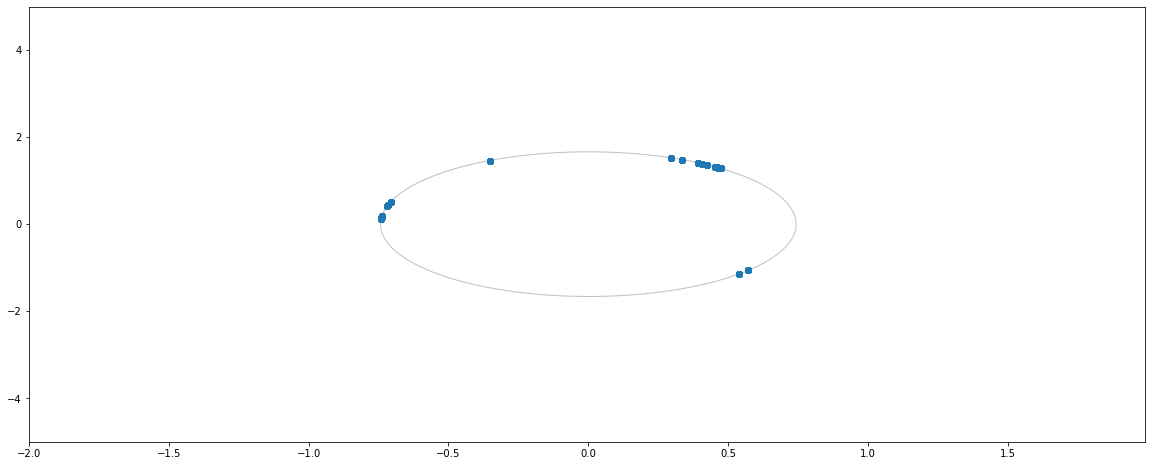

In [280]:
quick_MVN_scatter(hug, target, levels=[np.exp(z0)], lw=1, alpha=0.5, xlims=[-2, 2], ylims=[-5,5])

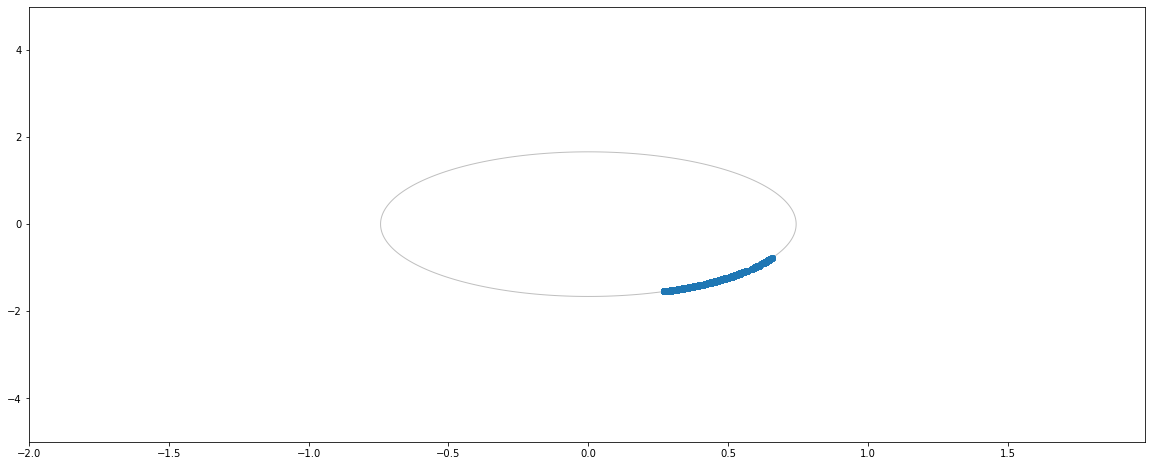

In [281]:
quick_MVN_scatter(thug, target, levels=[np.exp(z0)], lw=1, alpha=0.5, xlims=[-2, 2], ylims=[-5,5])

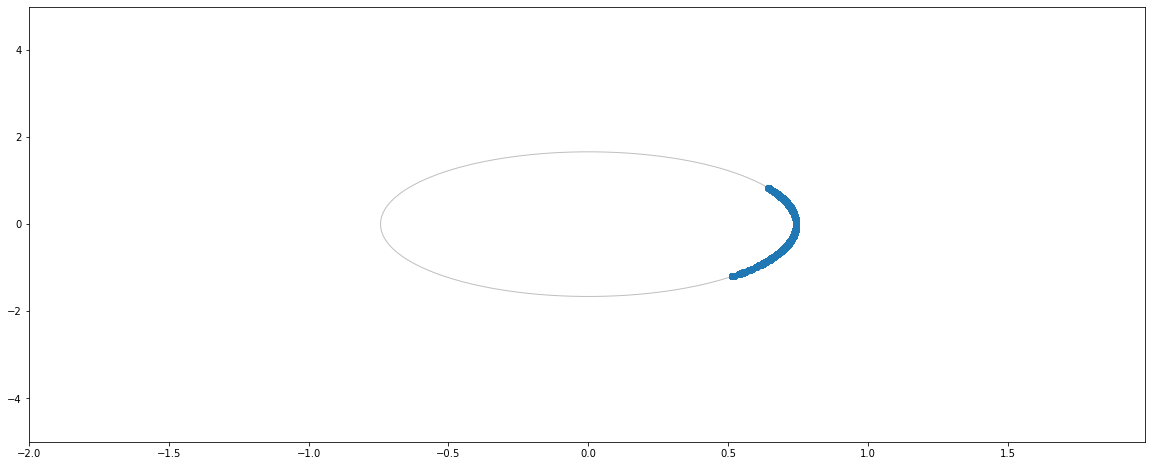

In [282]:
quick_MVN_scatter(thugar, target, levels=[np.exp(z0)], lw=1, alpha=0.5, xlims=[-2, 2], ylims=[-5,5])

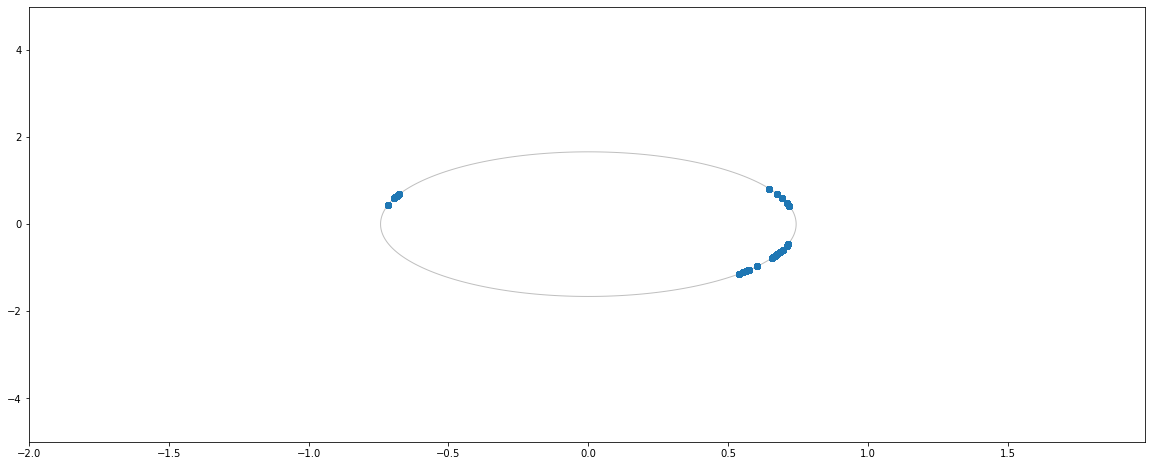

In [283]:
quick_MVN_scatter(rhug, target, levels=[np.exp(z0)], lw=1, alpha=0.5, xlims=[-2, 2], ylims=[-5,5])

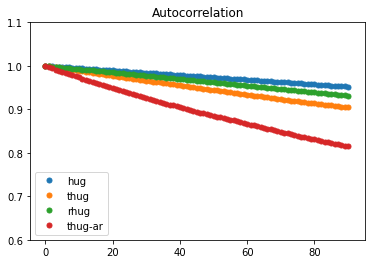

In [287]:
lags = 90
fig, ax = plt.subplots()
_ = plot_acf(hug[:, 0], ax, lags=lags, use_vlines=False, label='hug')
_ = plot_acf(thug[:, 0], ax, lags=lags, use_vlines=False, label='thug')
_ = plot_acf(rhug[:, 0], ax, lags=lags, use_vlines=False, label='rhug')
_ = plot_acf(thugar[:, 0], ax, lags=lags, use_vlines=False, label='thug-ar')
ax.set_ylim([0.6, 1.1])
handles, labels = ax.get_legend_handles_labels() 
ax.legend(handles, labels)
plt.show()

In [81]:
v0s = q.rvs()          
g0 = grad_log_simulator(x0)       
g0 = g0 / norm(g0)              
v0 = v0s - alpha * g0 * (g0 @ v0s) # Tilt velocity
v, x = v0, x0                    # Housekeeping
logu = np.log(rand())            # Acceptance ratio
delta = T / B                    # Compute step size

for _ in range(B):
    x = x + delta*v/2           # Move to midpoint
    g = grad_log_simulator(x)          # Compute gradient at midpoint
    ghat = g / norm(g)          # Normalize 
    v = v - 2*(v @ ghat) * ghat # Reflect velocity using midpoint gradient
    x = x + delta*v/2           # Move from midpoint to end-point
# Unsqueeze the velocity
g = grad_log_simulator(x)
g = g / norm(g)
v = v + (alpha / (1 - alpha)) * g * (g @ v)
Dpot = log_abc_posterior(x) - log_abc_posterior(x0)
Dkin = q.logpdf(v)  - q.logpdf(v0s)
loga = Dpot + Dkin
a = np.exp(loga)
print("Potential Ratio: {}".format(np.exp(Dpot)))
print("Kinetic Ratio:   {}".format(np.exp(Dkin)))
print("AP:   {}".format(a))
print("Norm v0: {}".format(norm(v0)))
print("Norm v:  {}".format(norm(v)))
print("PDF diff: ", target.logpdf(x0) - target.logpdf(x))
print("post x0: ", np.exp(log_abc_posterior(x0)))
print("post x: ", np.exp(log_abc_posterior(x)))

Potential Ratio: 0.0
Kinetic Ratio:   0.0
AP:   0.0
Norm v0: 0.927654264973845
Norm v:  1014.3830415960122
PDF diff:  -0.0022755941734229346
post x0:  1.0
post x:  0.0


In [82]:
# coef = 3.0
# T = 1.5 * coef
# B = int(5 * coef)

v0s = q.rvs()          
g0 = grad_log_simulator(x0)       
g0 = g0 / norm(g0)              
v0 = v0s - alpha * g0 * (g0 @ v0s) # Tilt velocity
v0 = v0 * norm(v0s) / norm(v0)
v, x = v0, x0                    # Housekeeping
logu = np.log(rand())            # Acceptance ratio
delta = T / B                    # Compute step size

for _ in range(B):
    x = x + delta*v/2           # Move to midpoint
    g = grad_log_simulator(x)          # Compute gradient at midpoint
    ghat = g / norm(g)          # Normalize 
    v = v - 2*(v @ ghat) * ghat # Reflect velocity using midpoint gradient
    x = x + delta*v/2           # Move from midpoint to end-point
# Unsqueeze the velocity
g = grad_log_simulator(x)
g = g / norm(g)
v = v + (alpha / (1 - alpha)) * g * (g @ v)
v = v * norm(v0s) / norm(v)
Dpot = log_abc_posterior(x) - log_abc_posterior(x0)
Dkin = q.logpdf(v)  - q.logpdf(v0s)
loga = Dpot + Dkin
a = np.exp(loga)
print("Potential Ratio: {}".format(np.exp(Dpot)))
print("Kinetic Ratio:   {}".format(np.exp(Dkin)))
print("AP:   {}".format(a))
print("Norm v0: {}".format(norm(v0)))
print("Norm v:  {}".format(norm(v)))
print("PDF diff: ", target.logpdf(x0) - target.logpdf(x))
print("post x0: ", np.exp(log_abc_posterior(x0)))
print("post x: ", np.exp(log_abc_posterior(x)))

Potential Ratio: 0.0
Kinetic Ratio:   0.9999999999999996
AP:   0.0
Norm v0: 1.620254145215247
Norm v:  1.6202541452152472
PDF diff:  0.004714049507113849
post x0:  1.0
post x:  0.0


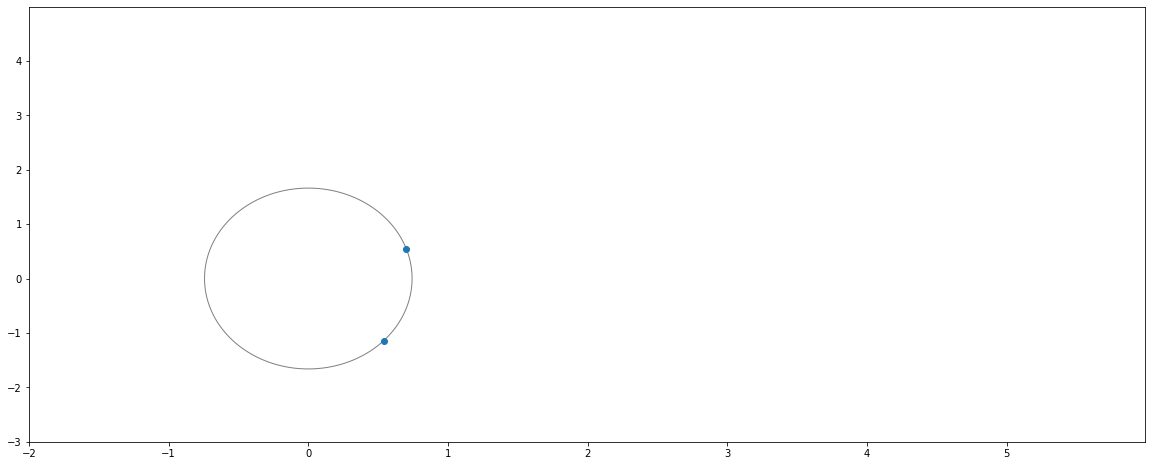

In [79]:
quick_MVN_scatter(np.vstack((x0, x)), target, levels=[target.pdf(x0)], lw=1)

In [24]:
epsilon = 0.001
alpha = 0.999

In [25]:
stuff, ap = HugRotated(x0, T, B, 100, alpha, q, log_abc_posterior, grad_log_simulator)

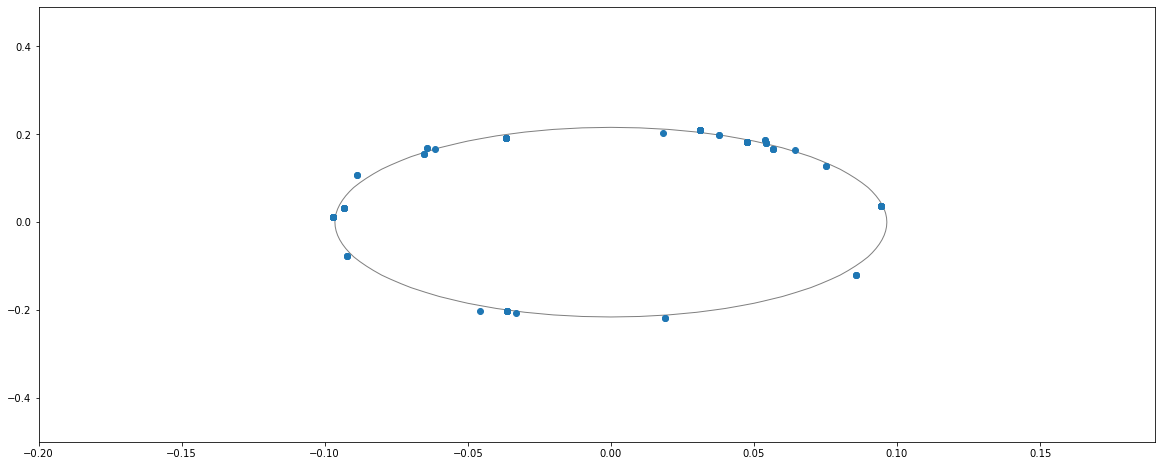

In [26]:
quick_MVN_scatter(stuff, target, levels=[target.pdf(x0)], lw=1, xlims=[-0.2, 0.2], ylims=[-0.5,0.5])

In [27]:
mean(ap)*100

22.0

# TEST

In [32]:
samples_rot, _ = HugRotated(x0, T, B, N, 0.99999, q, log_abc_posterior, grad_log_simulator)

In [33]:
samples_hug, _ = Hug(x0, T, B, N, q, log_abc_posterior, grad_log_simulator)

In [34]:
samples_thug, _ = HugTangential(x0, T, B, N, alpha, q, log_abc_posterior, grad_log_simulator)

In [35]:
n_unique(samples_hug), n_unique(samples_rot), n_unique(samples_thug)

(19, 54, 417)

In [36]:
ESS(samples_hug), ESS(samples_rot), ESS(samples_thug)

(101.70136396289963, 116.68081321256345, 104.40913780440434)

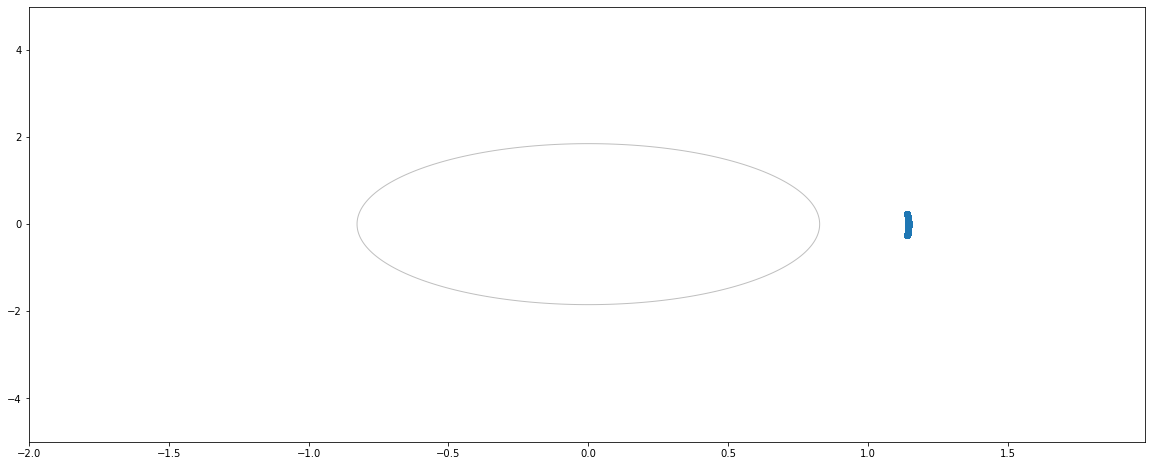

In [58]:
quick_MVN_scatter(samples_rot, target, levels=[target.pdf(x0)], lw=1, alpha=0.5, xlims=[-2, 2], ylims=[-5,5])

# INVOLUTION

In [138]:
def involution(x0, v0, delta=0.3, alpha=0.9):
    x, v = x0, v0
    # Rotate
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - alpha * (v @ g) * g
    v = v * norm(v0) / norm(v)
    # Move 
    x = x + delta * v / 2
    # Reflect
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - 2 * (v @ g) * g
    # Move
    x = x + delta * v / 2
    # Unrotate
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v + (alpha / (1-alpha)) * (v @ g) * g
    v = v * norm(v0) / norm(v)
    return x, -v  # Return negated velocity

In [135]:
alpha = 0.99999
v0 = q.rvs()
x1, v1 = involution(x0, v0, alpha=alpha)
x0new, v0new = involution(x1, v1, alpha=alpha)
np.max(abs(x0 - x0new)), np.max(abs(v0 - v0new))

Norm v:  116066.59490503429
Norm v:  3.3064280845694514


(9.262590694447681e-13, 9.013140902514039e-07)

In [124]:
target.logpdf(x0) - target.logpdf(x1)

-0.0074770144701372665

In [125]:
delta, delta**2, delta**3

(0.3, 0.09, 0.026999999999999996)

I NEED TO PERFORM THOSE CALCULATIONS MORE ACCURATELY AND ROBUSTLY.

THE PROBLEM IS THAT WHEN UNSQUEEZING WE GET A HUGE V

# Do we get same point with THUG and RHUG

In [136]:
v0 = q.rvs()

In [137]:
involution(x0, v0)

Norm v:  1.644323379391863


(array([ 0.65551756, -0.78239612]), array([-1.01479178, -0.74685192]))

In [140]:
thug(x0, v0)

(array([ 0.62977445, -0.88275135]), array([-1.05069195, -0.65269935]))

In [139]:
def thug(x0, v0, delta=0.3, alpha=0.9):
    x, v = x0, v0
    # Squeeze
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - alpha * (v @ g) * g
    # Move 
    x = x + delta * v / 2
    # Reflect
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - 2 * (v @ g) * g
    # Move
    x = x + delta * v / 2
    # Unrotate
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v + (alpha / (1-alpha)) * (v @ g) * g
    return x, -v  # Return negated velocity

In [142]:
g0 = grad_log_simulator(x0) / norm(grad_log_simulator(x0))
w0 = v0 - alpha * (v0 @ g0) * g0
# Move 
xh = x0 + delta * w0 / 2
# Reflect
gh = grad_log_simulator(xh) / norm(grad_log_simulator(xh))
w1 = w0 - 2 * (w0 @ gh) * gh
# Move
x1 = xh + delta * w1 / 2
# Unrotate
g1 = grad_log_simulator(x1) / norm(grad_log_simulator(x1))
v1 = w1 + (alpha / (1-alpha)) * (w1 @ g1) * g1

In [174]:
ww0 = w0 * norm(v0) / norm(w0)
# Move 
xxh = x0 + delta * ww0 / 2
# Reflect
ggh = grad_log_simulator(xxh) / norm(grad_log_simulator(xxh))
ww1 = ww0 - 2 * (ww0 @ ggh) * ggh
# Move
xx1 = xxh + delta * ww1 / 2
# Unrotate
gg1 = grad_log_simulator(xx1) / norm(grad_log_simulator(xx1))
vv1 = ww1 + (alpha / (1-alpha)) * (ww1 @ gg1) * gg1

(-2.0, 0.0)

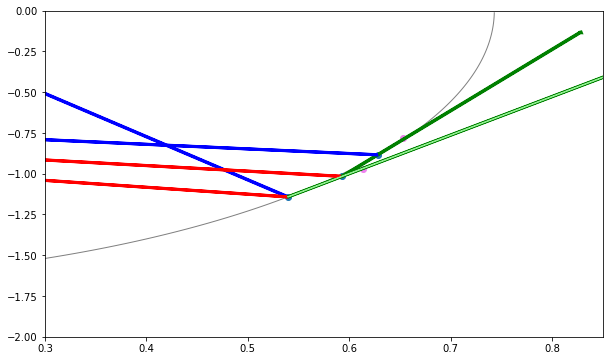

In [192]:
xlims = [0.3, 0.85]
ylims = [-2, 0.0]
step = 0.01
figsize=(10, 6)
lw=1
levels = [target.pdf(x0)]
colors = 'gray'

# Grid of points for contour plot
x, y = np.mgrid[xlims[0]:xlims[1]:step, ylims[0]:ylims[1]:step]
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=figsize)

ax.contour(x, y, target.pdf(pos), linewidths=lw, levels=levels, alpha=alpha, zorder=1, colors=colors) 
ax.scatter(*np.vstack((x0, xh, x1)).T)
ax.arrow(*x0, *v0, color='blue', lw=3)
ax.arrow(*x0, *g0, color='red', lw=3)
ax.arrow(*x0, *w0, color='green', lw=3)
ax.arrow(*xh, *gh, color='red', lw=3)
ax.arrow(*xh, *w1, color='green', lw=3)
ax.arrow(*x1, *v1, color='blue', lw=3)
# rhug
ax.scatter(*xxh, color='violet')
ax.scatter(*xx1, color='violet')
ax.arrow(*x0, *ww0, color='lightgreen')
# ax.arrow(*xxh, *ggh, color='orange')
# ax.arrow(*xxh, *ww1, color='lightgreen')
# ax.arrow(*xx1, *vv1, color='lightblue')
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# ROTATED HUG

In [289]:
import numpy as np
from numpy import load, arange, linspace
import matplotlib.pyplot as plt
from utils import box_plot

In [290]:
folder = "experiment22/"

# HUG
THETA_ESS_HUG = load(folder + "THETA_ESS_HUG.npy")
U_ESS_HUG     = load(folder + "U_ESS_HUG.npy")
ESS_HUG       = load(folder + "ESS_JOINT_HUG.npy")
A_HUG         = load(folder + "A_HUG.npy")
RMSE_HUG      = load(folder + "RMSE_HUG.npy")
EJSD_HUG      = load(folder + "EJSD_HUG.npy")
G_EJSD_HUG    = load(folder + "G_EJSD_HUG.npy")
T_EJSD_HUG    = load(folder + "T_EJSD_HUG.npy")
A_HOP_HUG     = load(folder + "A_HOP_HUG.npy")
N_UNIQUE_HUG  = load(folder + "N_UNIQUE_HUG.npy")
THETA_AC_HUG  = load(folder + "THETA_AC_HUG.npy")
U_AC_HUG      = load(folder + "U_AC_HUG.npy")

# RHUG
THETA_ESS_RHUG = load(folder + "THETA_ESS_RHUG.npy")
U_ESS_RHUG     = load(folder + "U_ESS_RHUG.npy")
ESS_RHUG       = load(folder + "ESS_JOINT_RHUG.npy")
A_RHUG         = load(folder + "A_RHUG.npy")
RMSE_RHUG      = load(folder + "RMSE_RHUG.npy")
EJSD_RHUG      = load(folder + "EJSD_RHUG.npy")
G_EJSD_RHUG    = load(folder + "G_EJSD_RHUG.npy")
T_EJSD_RHUG    = load(folder + "T_EJSD_RHUG.npy")
A_HOP_RHUG     = load(folder + "A_HOP_RHUG.npy")
N_UNIQUE_RHUG  = load(folder + "N_UNIQUE_RHUG.npy")
THETA_AC_RHUG  = load(folder + "THETA_AC_RHUG.npy")
U_AC_RHUG      = load(folder + "U_AC_RHUG.npy")

# COMMON
EPSILONS       = load(folder + "EPSILONS.npy")
ALPHAS         = load(folder + "ALPHAS.npy")

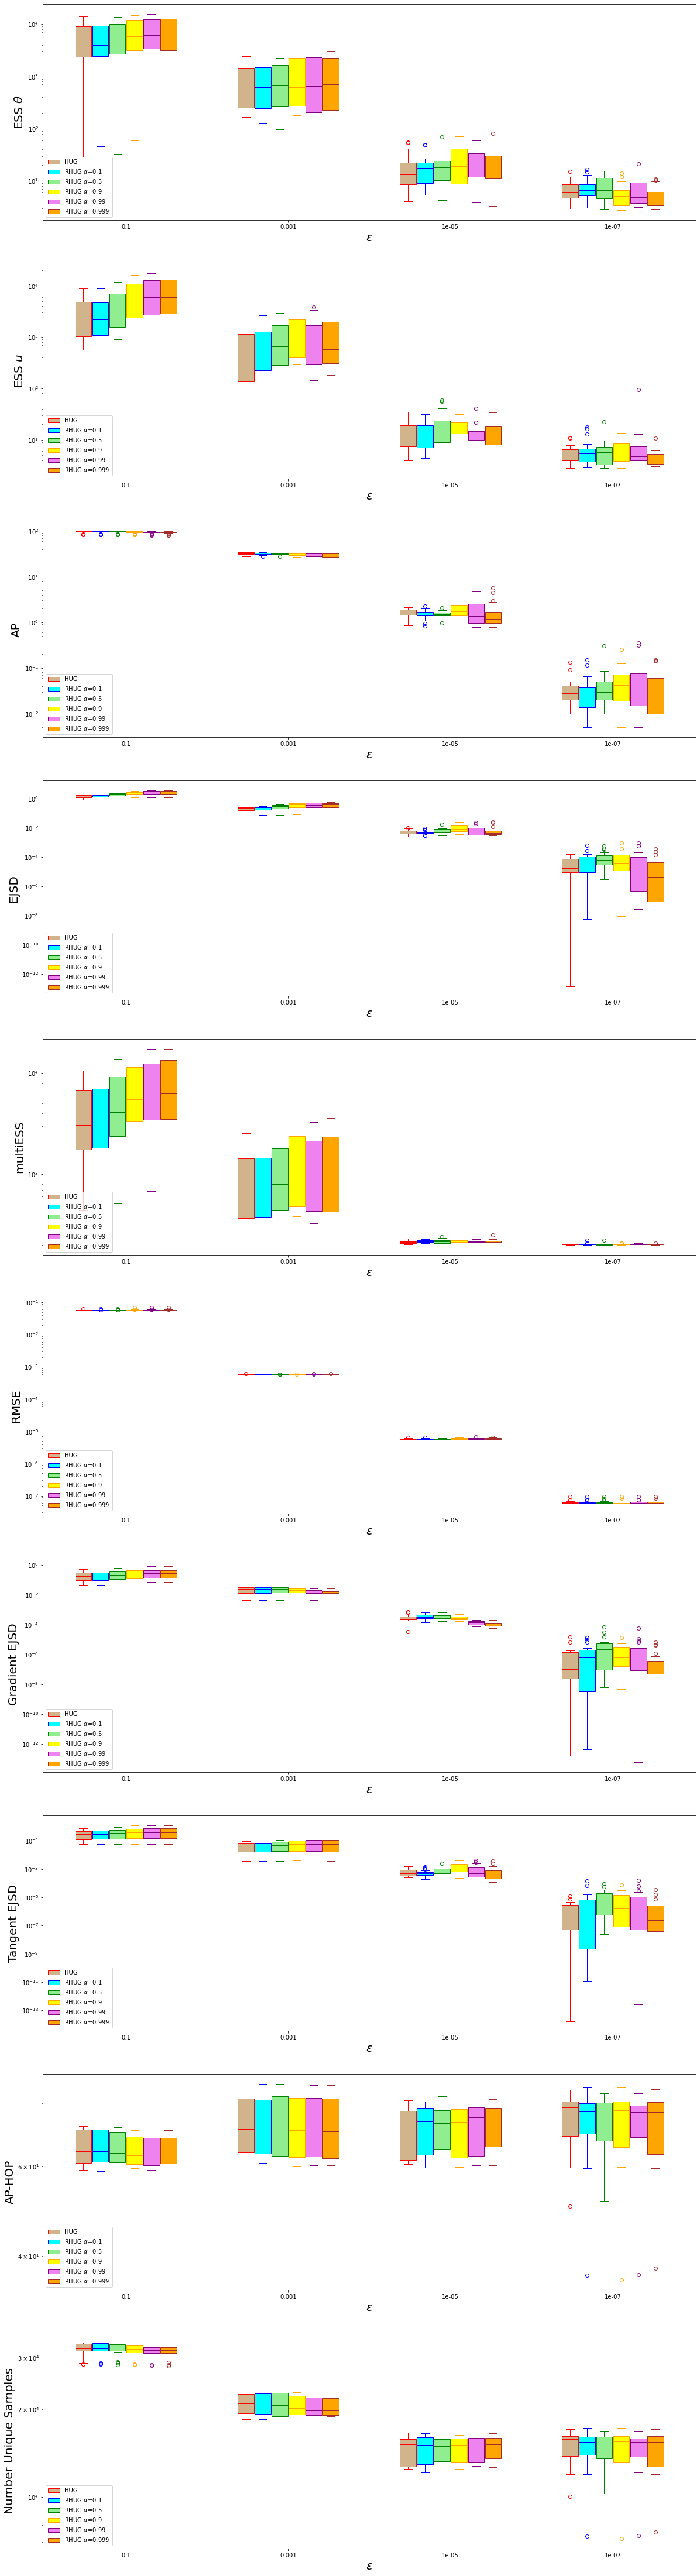

In [291]:
columns = EPSILONS
width = 0.21
thing_that_changes = ALPHAS
n_alphas = len(thing_that_changes)
ticks = arange(start=1, stop=len(columns)*2, step=2)
n_boxes = n_alphas + 1
disp = linspace(-width * (n_boxes-1) / 2, width * (n_boxes-1) / 2, n_boxes, endpoint=True)
positions = disp.reshape(-1, 1) + ticks
colors1 = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black']
colors2 = ['tan', 'cyan', 'lightgreen', 'yellow', 'violet', 'orange', 'lightgray']
labels = ['HUG'] + ['RHUG $\\alpha$={}'.format(thing) for thing in thing_that_changes]

ARRAYS = [
    (THETA_ESS_HUG, THETA_ESS_RHUG),
    (U_ESS_HUG, U_ESS_RHUG),
    (A_HUG, A_RHUG),
    (EJSD_HUG, EJSD_RHUG),
    (ESS_HUG, ESS_RHUG),
    (RMSE_HUG, RMSE_RHUG),
    (G_EJSD_HUG, G_EJSD_RHUG),
    (T_EJSD_HUG, T_EJSD_RHUG),
    (A_HOP_HUG, A_HOP_RHUG),
    (N_UNIQUE_HUG, N_UNIQUE_RHUG)
]
YLABELS = [
    'ESS $\\theta$', 
    'ESS $u$',
    'AP',
    'EJSD',
    'multiESS',
    'RMSE',
    'Gradient EJSD',
    'Tangent EJSD',
    'AP-HOP',
    'Number Unique Samples'
]
n_plots = len(ARRAYS)
fig, ax = plt.subplots(nrows=n_plots, figsize=(20, 8 * n_plots))
for ix, (array1, array2) in enumerate(ARRAYS):
    bp1 = box_plot(ax[ix], array1.T.tolist(), 'red', 'tan', positions[0])
    bps = []
    for i in range(n_alphas):
        bps.append(box_plot(ax[ix], array2[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
    handles = [bp1["boxes"][0]] + [bp["boxes"][0] for bp in bps]
    ax[ix].legend(
        handles, 
        labels, 
        loc='lower left')
    ax[ix].set_xticks(ticks)
    ax[ix].set_xticklabels(columns)
    ax[ix].set_xlabel("$\\epsilon$", fontsize=20)
    ax[ix].set_ylabel(YLABELS[ix], fontsize=20)
    ax[ix].semilogy()

plt.show()

In [292]:
def invol(x0, v0, delta=0.3, alpha=0.9):
    x, v = x0, v0
    # Squeeze
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - alpha * (v @ g) * g
    # Move 
    x = x + delta * v / 2
    # Reflect
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v - 2 * (v @ g) * g
    # Move
    x = x + delta * v / 2
    # Unsqueeze
    g = grad_log_simulator(x) / norm(grad_log_simulator(x))
    v = v + (alpha / (1-alpha)) * (v @ g) * g
    # Rescale
    v = v * norm(v0) / norm(v)
    return x, -v  # Return negated velocity

In [294]:
v0 = q.rvs()

In [326]:
x0, v0

(array([ 0.53946173, -1.1421292 ]), array([2.19463828, 1.74181416]))

In [327]:
x1, v1 = invol(x0, v0)

In [328]:
x2, v2 = invol(x1, v1)

In [354]:
g0 = grad_log_simulator(x0) / norm(grad_log_simulator(x0))
v0squeezed = v0 - alpha * (v0 @ g0) * g0
xhalf = (x0 + delta*v0squeezed/2)
ghalf = grad_log_simulator(xhalf) / norm(grad_log_simulator(xhalf))
v0squeezed_reflected = v0squeezed - 2 * (v0squeezed @ ghalf) * ghalf
x1 = xhalf + delta * v0squeezed_reflected / 2
g1 = grad_log_simulator(x1) / norm(grad_log_simulator(x1))
v0unsqueezed = v0squeezed_reflected + (alpha / (1-alpha)) * (v0squeezed_reflected @ g1) * g1
v0unsqueezed_normalized = v0unsqueezed / norm(v0unsqueezed)
v0unsqueezed_renormalized = v0unsqueezed_normalized * norm(v0)
w1 = v0unsqueezed_renormalized - alpha * (v0unsqueezed_renormalized @ g1) * g1  # squeeze at endpoint

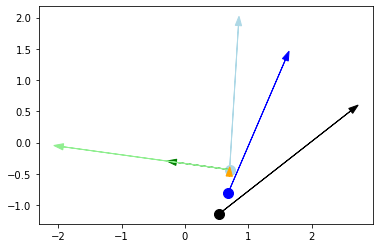

In [355]:
fig, ax = plt.subplots()
ax.scatter(*x0, s=100, color='black')
ax.scatter(*xhalf, s=100, color='blue')
ax.scatter(*x1, s=100, color='lightblue')
ax.arrow(*x0, *v0, length_includes_head=True, head_width=0.1, color='black')
ax.arrow(*xhalf, *v0squeezed, length_includes_head=True, head_width=0.1, color='blue')
ax.arrow(*x1, *v0squeezed_reflected, length_includes_head=True, head_width=0.1, color='lightblue')
ax.arrow(*x1, *v0unsqueezed_normalized, length_includes_head=True, head_width=0.1, color='green')
ax.arrow(*x1, *v0unsqueezed_renormalized, length_includes_head=True, head_width=0.1, color='lightgreen')
ax.arrow(*x1, *w1, length_includes_head=True, head_width=0.1, color='orange')